<p><img alt="Colaboratory logo" height="45px" src="/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px"></p>

#<h1>Import packages</h1>

In [ ]:
import easydict
import os
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import torchvision

import pandas as pd
from tqdm import tqdm 
import time

from random import randint
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from IPython.display import HTML
from matplotlib import rc
%matplotlib inline

import copy as cp
from IPython.display import clear_output

 
use_cuda = True
if torch.cuda.is_available():
  device = torch.device("cuda")


np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%.3g" % x))

cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [ ]:
os.makedirs("images", exist_ok=True)
opt = easydict.EasyDict({ "n_epochs": 450, 
                          "steps":3,
                          "batch_size": 256 , 
                          "lr": 3e-4, 
                          "b1": 0.9,
                          "b2": 0.999,
                          "weight_decay": 0.0001,
                          "input_dim": 40,
                          "output_dim": 40,
                          "z_dim": 128 ,
                          "goal_dim": 6,
                          "n_cpu": 8,
                          "re_size": 128,
                          "wKLDMAX":0.00001,
                          "start_wKLD": 0,
                          "duration_wKLD": 2000,
                          "sample_interval": 400 })
print(opt)
 
# cuda = True if torch.cuda.is_available() else False
# Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

{'n_epochs': 450, 'steps': 3, 'batch_size': 256, 'lr': 0.0003, 'b1': 0.9, 'b2': 0.999, 'weight_decay': 0.0001, 'input_dim': 40, 'output_dim': 40, 'z_dim': 128, 'goal_dim': 6, 'n_cpu': 8, 're_size': 128, 'wKLDMAX': 1e-05, 'start_wKLD': 0, 'duration_wKLD': 2000, 'sample_interval': 400}


In [ ]:
def LossPlot(train_loss, loss_01, loss_02):
    fig = plt.figure()
    fig.suptitle("Train loss : "+str(train_loss[-1]))
    offset = 50
    
    ax1 = host_subplot(111, axes_class=AA.Axes)
    loss1,=ax1.plot(loss_01, color='g', label='BCE loss')
    ax1.set_xlabel("Steps")
    ax1.set_ylabel("Reconstruction")
    ax1.yaxis.label.set_color('g')
    
    ax2 = ax1.twinx()
    new_fixed_axis = ax2.get_grid_helper().new_fixed_axis
    ax2.axis["right"] = new_fixed_axis(loc="right", axes=ax2, offset=(0, 0))
    loss2,=ax2.plot(train_loss, color='b', label='Train loss')
    ax2.set_xlabel("Steps")
    ax2.set_ylabel("Losses")
    ax2.yaxis.label.set_color('b')
    
    ax3 = ax1.twinx()
    new_fixed_axis = ax3.get_grid_helper().new_fixed_axis
    ax3.axis["right"] = new_fixed_axis(loc="right", axes=ax3, offset=(offset, 0))
    loss3,=ax3.plot(loss_02, color='r', label='KLD loss')
    ax3.set_xlabel("Steps")
    ax3.set_ylabel("K-L divergence")
    ax3.yaxis.label.set_color('r')
 
    graphs=[loss1, loss2, loss3]
    ax3.legend(graphs, [curve.get_label() for curve in graphs])
    plt.show()
    fig.tight_layout()
    fig.savefig('/content/drive/MyDrive/Colab Notebooks/graph/LearningLoss.png',dpi=100)

<p><img alt="Colaboratory logo" height="45px" src="/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px"></p>

#<h1>Terrain data organization</h1>

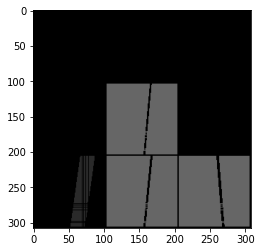

In [ ]:
# Place data into dataloader
class GenTerrainDataset(Dataset):
 
  def __init__(self, TerrainData, transform=None):
      self.data = TerrainData.float()
      self.transform = transform
      
  def __getitem__(self, index):
      data = self.data
      if self.transform:
            data = self.transform(data[index])

      return index, data
 
  def __len__(self):
      return len(self.data)

TESTterrain=torch.tensor(np.load('/content/drive/MyDrive/Colab Notebooks/data/Terrain_XYZ_tensor.npy')[:,2]).view(-1,1,100,100)
TESTterrain[-5999:] -= TESTterrain[-5999:].min()
transform = transforms.Compose(
    [
     transforms.ToPILImage(),
    #  transforms.Resize((opt.re_size, opt.re_size)),
     transforms.ToTensor(),
    #  transforms.Normalize(mean=[mean], std=[std]),
    ])

def show(img,nrow=3):
  # img = img*std + mean
  img_grid = torchvision.utils.make_grid(img,nrow=nrow).numpy()
  plt.figure()
  plt.imshow(np.transpose(img_grid, (1,2,0)))
  plt.axis('on')
  plt.show()
  
terrain_dataset = GenTerrainDataset(TESTterrain, transform=transform)
terrain_dataloader = DataLoader(terrain_dataset,batch_size=opt.batch_size,shuffle=True)

_, img = next(iter(terrain_dataloader))
NUMrow = 3
# Input
show(img[:9].cpu(),nrow=NUMrow)

<p><img alt="Colaboratory logo" height="45px" src="/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px"></p>

#<h1>Autoencoder structure</h1>

In [ ]:
class VanillaVAE(nn.Module):
  def __init__(self): 
        super(VanillaVAE, self).__init__()
        latent_dim = arg.z_dim
        self.latent_dim = latent_dim
        self.im_channels = in_channels = 1

        modules = []
        hidden_dims = [32, 64, 64, 128, 256]
        self.hidden_dims = hidden_dims.copy()

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.LatentSpace = nn.Linear(hidden_dims[-1]*4, latent_dim)

        # Build Decoder
        modules = []
        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1]*4)
        hidden_dims.reverse()
        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )
        self.decoder = nn.Sequential(*modules)
        self.final_layer = nn.Sequential(
                                        nn.ConvTranspose2d(hidden_dims[-1],
                                                            hidden_dims[-1],
                                                            kernel_size=3,
                                                            stride=2,
                                                            padding=1,
                                                            output_padding=1),
                                        nn.BatchNorm2d(hidden_dims[-1]),
                                        nn.LeakyReLU(),
                                        nn.Conv2d(hidden_dims[-1], out_channels= self.im_channels,
                                                  kernel_size= 3, padding= 1),
                                        nn.Tanh())

  def encode(self, input: Tensor):
      result = self.encoder(input)
      result = torch.flatten(result, start_dim=1)
      latent = self.LatentSpace(result)

      return latent

  def decode(self, z: Tensor):
      result = self.decoder_input(z)
      result = result.view(-1, self.hidden_dims[-1], 2, 2)
      result = self.decoder(result)
      result = self.final_layer(result)

      return result

  def forward(self, input: Tensor, **kwargs):
      z = self.encode(input)
      recon = self.decode(z)
      return  [recon, input, z]

  def loss_function(self,
                    *args,
                    **kwargs):
      recons = args[0]
      input = args[1]
      recons_loss =F.mse_loss(recons, input)

      return {'loss': recons_loss}

<p><img alt="Colaboratory logo" height="45px" src="/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px"></p>

#<h1>Autoencoder Load</h1>

In [ ]:
model = VanillaVAE()
if cuda:
    model.cuda()
optimizer = optim.Adam( filter(lambda p: p.requires_grad, model.parameters()), lr=opt.lr, weight_decay=opt.weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=int(opt.n_epochs/opt.steps), gamma=0.7) # 0.7^5 = 0.16

In [ ]:
# # Load CHECK POINT
# # params = torch.load("/content/drive/MyDrive/Colab Notebooks/model/TerrainEncoder_.tar", map_location = "cpu")
params = torch.load("/content/drive/MyDrive/Colab Notebooks/model/TerrainEncoder.tar", map_location = "cpu")
model.load_state_dict(params['model_state_dict'])

<All keys matched successfully>

<p><img alt="Colaboratory logo" height="45px" src="/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px"></p>

#<h1>Autoencoder Train</h1>

In [ ]:
model.train()

train_loss=[]

for epoch in tqdm(range(opt.n_epochs), position=0, leave=True):
    AVG_loss = 0
    batch_cnt = 0
    wKLD = min( max(epoch-opt.start_wKLD,0)/opt.duration_wKLD, 1)

    for batch_idx, TerrainData in enumerate(terrain_dataloader):
      # Clear ipython output
      clear_output(wait=True)

      input_data = TerrainData[1]
      input_data = Variable(input_data.type(Tensor))

      optimizer.zero_grad()

      result = model(input_data)

      loss_dict = model.loss_function(*result, M_N=opt.wKLDMAX*wKLD)
      loss = loss_dict['loss']

      loss.backward()
      optimizer.step()
      
      AVG_loss += loss.item()
      batch_cnt += 1

      # Print progession
      print(
            "[Epoch %d/%d] [Batch %d/%d] [loss: %f]"
            % (epoch, opt.n_epochs, batch_idx % len(terrain_dataloader), len(terrain_dataloader), loss.item())
        )
      # Save checkpoint
      if batch_idx%2 == 0:
        torch.save({'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'loss': loss},
                  "/content/drive/My Drive/Colab Notebooks/model/TerrainEncoder.tar", pickle_protocol = 4)
      else:
        torch.save({'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'loss': loss},
                  "/content/drive/My Drive/Colab Notebooks/model/TerrainEncoder_.tar", pickle_protocol = 4)
      
    # Save train loss
    train_loss.append(AVG_loss/batch_cnt)
    # Plot loss curves
    fig = plt.figure()
    fig.suptitle("Train loss : "+str(train_loss[-1]))
    plt.plot(train_loss, color='b', label='Train loss')
    plt.xlabel("Steps")
    plt.ylabel("Losses")
    fig.savefig('/content/drive/MyDrive/Colab Notebooks/graph/LearningLoss.png',dpi=100)
        
    scheduler.step()
 
# Save model & parameters
torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss},
            "/content/drive/My Drive/Colab Notebooks/model/TerrainEncoder_"+str(t.tm_year)+str(t.tm_mon)+str(t.tm_mday)+str(t.tm_hour)+str(t.tm_min)+".tar", pickle_protocol = 4)

<p><img alt="Colaboratory logo" height="45px" src="/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px"></p>

#<h1>Autoencoder Test</h1>

In [ ]:
# Load terrian data
# TESTterrain=torch.tensor(np.load('/content/drive/MyDrive/Colab Notebooks/data/Terrain_XYZ.npy')[:,2]).view(-1,1,64,64)
TESTterrain=torch.tensor(np.load('/content/drive/MyDrive/Colab Notebooks/data/Terrain_XYZ_tensor.npy')[:,2]).view(-1,1,64,64)
TESTterrain[-5999:] -= TESTterrain[-5999:].min()
transform = transforms.Compose(
    [
     transforms.ToPILImage(),
    #  transforms.Resize((opt.re_size, opt.re_size)),
     transforms.ToTensor(),
    #  transforms.Normalize(mean=[mean], std=[std]),
    ])
# TESTterrain = torch.tensor(np.load('/content/drive/MyDrive/Colab Notebooks/data/Terrain_XYZ.npy'))
# TESTterrain=torch.tensor(TESTterrain[2].reshape(-1,1,100,100))
# TESTterrain=torch.tensor(np.load('/content/drive/MyDrive/Colab Notebooks/data/Terrain_XYZ.npy')[:,2]).view(-1,1,100,100)


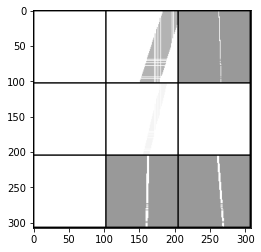

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


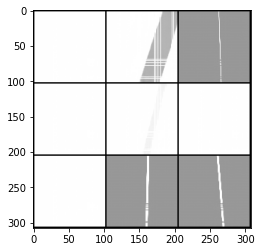

In [ ]:
def show(img,nrow=3):
  # img = img*std + mean
  img_grid = torchvision.utils.make_grid(img,nrow=nrow).numpy()
  plt.figure()
  plt.imshow(np.transpose(img_grid, (1,2,0)))
  plt.axis('on')
  plt.show()
  
  
# terrain_test_dataset = GenTerrainDataset(TESTterrain, transform=transform)
# terrain_test_dataloader = DataLoader(terrain_test_dataset,batch_size=9,shuffle=True)
terrain_test_dataset = GenTerrainDataset(TESTterrain, transform=transform)
terrain_test_dataloader = DataLoader(terrain_test_dataset,batch_size=9,shuffle=True)

_, img = next(iter(terrain_test_dataloader))
# TEST = img/0.4
TEST = img
model.eval().cpu()
pred = model(TEST)
input = pred[1]
output = pred[0]

NUMrow = 3
# Input
show(1-input.cpu(),nrow=NUMrow)
# Output
show(1-(output).detach().cpu(),nrow=NUMrow)

In [ ]:
torch.mean(output-input)

tensor(0.0013, grad_fn=<MeanBackward0>)